# Setting up the modules 

In [1]:
# common libraries
import sys, glob, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# analysis related modules
from scipy.stats import entropy, spearmanr
from scipy import interp
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, roc_curve, auc
from sklearn.model_selection import KFold, GroupKFold
from collections import Counter

In [3]:
# keras modules
import tensorflow as tf
# from keras.models import load_model


from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

# from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import plot_model
import keras_tqdm
from livelossplot.keras import PlotLossesCallback

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sjnam/anacond

In [4]:
# custom layers from external files
from layers.embeddings import ElmoLayer
from layers.attention import AttentionLayer
from models.build_models import build_model_elmo, initialize_vars
from models.train_models import train_elmomod_cv

In [5]:
# spacy for tokenizer
import spacy
from spacy.tokenizer import Tokenizer
# from spacy.lang.en import English

In [6]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)
tf.logging.set_verbosity(tf.logging.ERROR)

# import dataset 

In [7]:
df_contexts = pd.read_pickle('dataset/predicting_contextual_informativeness-master/kapelner_context.pickle')

In [8]:
df_contexts.head()

AttributeError: 'LazyConfigValue' object has no attribute 'lower'

   context_id  \
0  1564         
1  1566         
2  1571         
3  1580         
4  1581         

                                                                                                                                                                                                                                                                                                                                                                         context  \
0  The book Manipur: A Tourist Paradise is a unique milestone of tourism. It reveals that Manipur has unlimited untapped potential for the development of tourism in terms of exotic scenic natural beauty, fascinating wild life, salubrious climate and mosaic of enchanting cultures. It properly conceived and executed, it will prove to b of immense benefit to the state.   
1  Although as Billy Bragg, who knows a thing or two about the subject, once observed "All the great political music was made at the height of political 

## preprocessing model inputs

In [9]:
# nlp = spacy.load("en_core_web_lg")

# tokenizer = Tokenizer(nlp.vocab)



# # for doc in tokenizer.pipe(df_contexts['context'][62:63]):
# #     print(doc)

# # spacy lemmatizer does not work with rare words..?
# doc = nlp(u'''... "This is a diversionary tactic by WestJet to draw attention away from evidence filed in court by Air Canada on June 28 including the cross examination of one of WestJet's senior vice presidents, that WestJet surreptitiously and continuously for a ten month period, logged into an Air Canada confidential website using automated technology," Air Canada said in a release.''')
# for token in doc:
#     print(token, token.lemma, token.lemma_)

In [10]:
# some constants
RDM_SEED = 1
K_FOLDS = 10          # in the Kapelner et al.2018 paper: using 10-fold CV, based on target word grouping
# MAX_SEQ_LEN = 20    # determine in the later block, based on the tokenization results
FILTERS = '"#$%&()*+/=@[\\]^_`{|}~\t\n' #'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

In [11]:
context_len = []
for sents in df_contexts['context']:
    context_len.append(len(text_to_word_sequence(sents, lower=False, filters=FILTERS)))
df_contexts['context_len'] = context_len

In [12]:
df_contexts['context_len'].describe()

count    70499.000000
mean     55.511071   
std      3.407092    
min      17.000000   
25%      53.000000   
50%      55.000000   
75%      58.000000   
max      131.000000  
Name: context_len, dtype: float64

In [13]:
MAX_SEQ_LEN = 140

In [14]:
_err_sent_idx = []
def proc_sentences(df, _maxlen, col_sentence, col_targ, col_score, incld_targ=True):
    sentences = []
    li_mask_LH = []
    li_mask_RH = []
    li_mask_cntx = []
    li_targ = []
    li_targ_idx = []
    li_sent_len = []
    li_sent_pad = []
    li_score = []
    for i in range(df.shape[0]):
        sent = df.iloc[i][col_sentence]
        
        targ = df.iloc[i][col_targ]
        score = df.iloc[i][col_score]
        try: 
            sent = sent.replace("<BOS>", "").replace(".", " .").replace(",", " ,").replace("!", " !").replace("?", " ?").replace("'s", " 's")
            sent_tok = text_to_word_sequence(sent, lower=False, filters=FILTERS)
            sent_pad = pad_sequences([sent_tok], maxlen=_maxlen, dtype='object', padding='post', value=[""])       
            targ_idx = np.where(targ==sent_pad[0])[0][0]
            if(~incld_targ):
                sent_pad[0][targ_idx] = "<UNK>"

            mask_LH = [0]*(MAX_SEQ_LEN)
            mask_RH = [0]*(MAX_SEQ_LEN)
            for i in range(targ_idx):
                mask_LH[i] = 1
            for i in range(targ_idx+1, len(sent_tok)):
                mask_RH[i] = 1

            sent_len = len(sent_tok)

            li_targ.append(targ)
            li_score.append(score)
            
            li_targ_idx.append(targ_idx)
            li_sent_len.append(sent_len)
            li_sent_pad.append(list(sent_pad)[0])
            li_mask_LH.append(mask_LH)
            li_mask_RH.append(mask_RH)
        except:
            _err_sent_idx.append(i)
#     sentences = [np.array(li_targ_idx), np.array(li_sent_len), np.array(li_sent_pad), np.array(li_targ)]
#     sentences = [np.array(li_targ_idx), np.array(li_sent_len), np.array(li_sent_pad)]
    sentences = [np.array(li_sent_len), np.array(li_sent_pad), # np.array(li_targ_idx),
                 np.array(li_mask_LH), np.array(li_mask_RH)] #, np.sum((li_mask_LH, li_mask_RH), axis=0)]
    if(incld_targ):
        return(sentences, li_targ, li_score)
    else:
        return(sentences, li_score)

In [15]:
sentences_wttarg_train, targets_train, info_scores_train = proc_sentences(df_contexts[df_contexts['dataset']==1], MAX_SEQ_LEN, 'context', 'target_word', 'mean_rating', True)
sentences_wttarg_test, targets_test, info_scores_test = proc_sentences(df_contexts[df_contexts['dataset']==2], MAX_SEQ_LEN, 'context', 'target_word', 'mean_rating', True)

In [16]:
sentences_notarg_train, targets_train = proc_sentences(df_contexts[df_contexts['dataset']==1], MAX_SEQ_LEN, 'context', 'target_word', 'mean_rating', False)
sentences_notarg_test, targets_test = proc_sentences(df_contexts[df_contexts['dataset']==2], MAX_SEQ_LEN, 'context', 'target_word', 'mean_rating', False)

In [17]:
len(_err_sent_idx)

3192

In [18]:
df_contexts.shape

(70499, 7)

In [19]:
len(sentences_wttarg_train[0])

34278

In [20]:
[sent[0] for sent in sentences_wttarg_train]

[64, array(['The', 'book', 'Manipur:', 'A', 'Tourist', 'Paradise', 'is', 'a',
        'unique', 'milestone', 'of', 'tourism', '.', 'It', 'reveals',
        'that', 'Manipur', 'has', 'unlimited', 'untapped', 'potential',
        'for', 'the', 'development', 'of', 'tourism', 'in', 'terms', 'of',
        'exotic', 'scenic', 'natural', 'beauty', ',', 'fascinating',
        'wild', 'life', ',', '<UNK>', 'climate', 'and', 'mosaic', 'of',
        'enchanting', 'cultures', '.', 'It', 'properly', 'conceived',
        'and', 'executed', ',', 'it', 'will', 'prove', 'to', 'b', 'of',
        'immense', 'benefit', 'to', 'the', 'state', '.', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', ''], dtype=object), array

In [21]:
[sent[0] for sent in sentences_notarg_train]

[64, array(['The', 'book', 'Manipur:', 'A', 'Tourist', 'Paradise', 'is', 'a',
        'unique', 'milestone', 'of', 'tourism', '.', 'It', 'reveals',
        'that', 'Manipur', 'has', 'unlimited', 'untapped', 'potential',
        'for', 'the', 'development', 'of', 'tourism', 'in', 'terms', 'of',
        'exotic', 'scenic', 'natural', 'beauty', ',', 'fascinating',
        'wild', 'life', ',', '<UNK>', 'climate', 'and', 'mosaic', 'of',
        'enchanting', 'cultures', '.', 'It', 'properly', 'conceived',
        'and', 'executed', ',', 'it', 'will', 'prove', 'to', 'b', 'of',
        'immense', 'benefit', 'to', 'the', 'state', '.', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', ''], dtype=object), array

In [22]:
# TODO: after fixing the lemmatization problem?
# df_contexts['target_loc'] = np.sum(sentences_wttarg[2], axis=1)

In [23]:
df_contexts.head(), df_contexts.shape

(   context_id  \
 0  1564         
 1  1566         
 2  1571         
 3  1580         
 4  1581         
 
                                                                                                                                                                                                                                                                                                                                                                          context  \
 0  The book Manipur: A Tourist Paradise is a unique milestone of tourism. It reveals that Manipur has unlimited untapped potential for the development of tourism in terms of exotic scenic natural beauty, fascinating wild life, salubrious climate and mosaic of enchanting cultures. It properly conceived and executed, it will prove to b of immense benefit to the state.   
 1  Although as Billy Bragg, who knows a thing or two about the subject, once observed "All the great political music was made at the height of 

In [24]:
# score_info = df_contexts['mean_rating']

# ELMo + Attention model

In [25]:
K.clear_session()
sess = tf.Session()

model = build_model_elmo(MAX_SEQ_LEN, attention_layer=True)
initialize_vars(sess)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sent_len (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_sentence (InputLayer)     [(None, 140)]        0                                            
__________________________________________________________________________________________________
input_mask_LH (InputLayer)      [(None, 140)]        0                                            
__________________________________________________________________________________________________
input_mask_RH (InputLayer)      [(None, 140)]        0                                            
______________________________________________________________________________________________

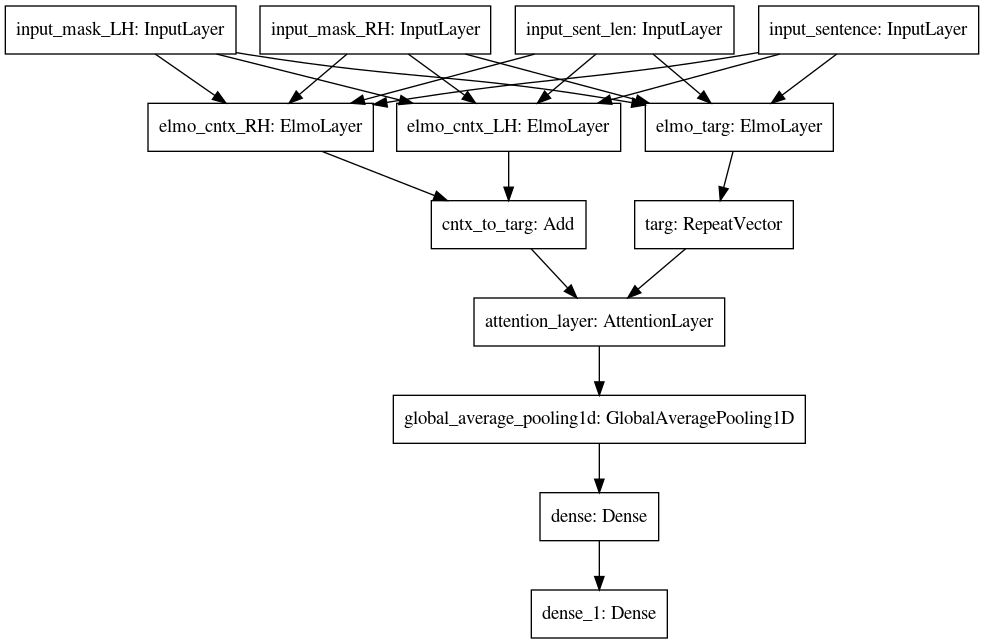

In [26]:
plot_model(model)

In [27]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11214075252565614609
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6807660517028848060
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10785472512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15817607437991822899
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17211032974187181899
physical_device_desc: "device: XLA_GPU device"
]


In [32]:
_num_iter = 10
_batch_size = 32

In [33]:
from livelossplot.keras import PlotLossesCallback

In [34]:
K.clear_session()
sess = tf.Session()
plot_losses = PlotLossesCallback()

# preparing
model = build_model_elmo(MAX_SEQ_LEN, attention_layer=True)
initialize_vars(sess)

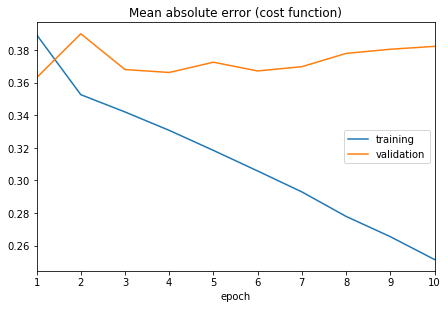

Mean absolute error (cost function):
training   (min:    0.252, max:    0.389, cur:    0.252)
validation (min:    0.363, max:    0.390, cur:    0.382)



In [35]:
# training
model.fit(x=sentences_notarg_train, y=info_scores_train, 
         epochs=_num_iter, batch_size=_batch_size, 
         validation_split=0.10, shuffle=True,
         verbose=0, 
         callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=True), 
                    plot_losses])
model.save_weights("./model_weights_kapelner/model_elmo_notarg_wtattn.h5")

In [36]:
# prediction
pred_test = np.reshape(model.predict(sentences_notarg_test, batch_size=_batch_size), -1)    
np.save("./model_predict_kapelner/preds_elmo_notarg_wtattn.npy", pred_test)

In [ ]:
sns.scatterplot(info_scores_test, pred_test, alpha=0.2)

# without attention 

In [44]:
K.clear_session()
sess = tf.Session()
model = build_model_elmo(MAX_SEQ_LEN, False)
initialize_vars(sess)

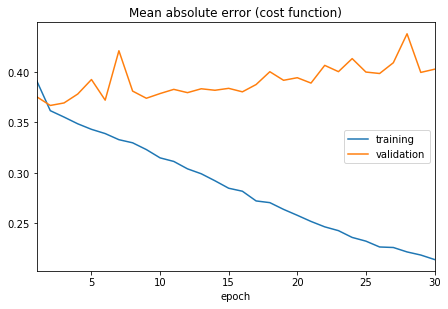

Mean absolute error (cost function):
training   (min:    0.214, max:    0.391, cur:    0.214)
validation (min:    0.367, max:    0.438, cur:    0.403)



In [45]:
model.fit(x=sentences_notarg_train, y=info_scores_train, 
         epochs=_num_iter, batch_size=_batch_size, 
         validation_split=0.10, shuffle=True,
         verbose=0, 
         callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=True), 
                    plot_losses])
model.save_weights("./model_weights_kapelner//model_elmo_notarg_noattn.h5")

In [47]:
# prediction
pred_scores = np.reshape(model.predict(sentences_notarg_test, batch_size=_batch_size), -1)    
np.save("./model_predict_kapelner/preds_elmo_notarg_noattn.npy", pred_scores)

In [48]:
pred_scores = np.load("model_predict_kapelner/preds_elmo_notarg_wtattn.npy")

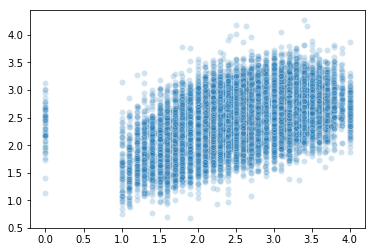

In [49]:
sns.scatterplot(info_scores_test, pred_scores, alpha=0.2)

In [50]:
spearmanr(info_scores_test, pred_scores)

SpearmanrResult(correlation=0.4540121780065574, pvalue=0.0)

In [51]:
mean_absolute_error(info_scores_test, pred_scores)

0.38750892577918433

In [52]:
pred_scores = np.load("model_predict_kapelner/preds_elmo_notarg_noattn.npy")

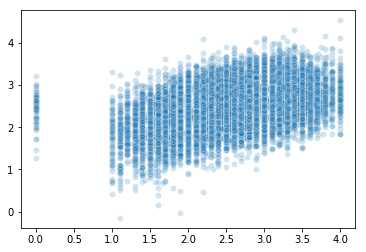

In [53]:
sns.scatterplot(info_scores_test, pred_scores, alpha=0.2)

In [54]:
spearmanr(info_scores_test, pred_scores)

SpearmanrResult(correlation=0.3877104230565413, pvalue=0.0)

In [55]:
mean_absolute_error(info_scores_test, pred_scores)

0.40947319923214964